<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/CNN_with_generated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN For Detecting Pneumonia From Orignal and DCGAN Generated X-Ray Images 

This notebook demonstrates classification of chest X-ray images with deep learning using a CNN from scratch. DCGAN generated 'NORMAL' images are added to the orginal X-ray dataset. 

## Using GPU

In [1]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Preperation

In [28]:
# listing the files in the directory
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/'

chest_xray  __MACOSX  normal_gan_added_to_train  test  val


In [32]:
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train/'
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train/'

test  train  val


In [33]:
# importing necessary packages
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [34]:
# assigning variables with the proper file path for the training, validation and test set
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [35]:
# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

In [36]:
# looking at how many images there are in each directory
dir = [train_normal_dir, train_pneumonia_dir, val_normal_dir,
            val_pneumonia_dir, test_normal_dir, test_pneumonia_dir]
dir_name = ['train_normal_dir', 'train_pneumonia_dir', 'val_normal_dir',
            'val_pneumonia_dir', 'test_normal_dir', 'test_pneumonia_dir']
for name, dir in zip(dir_name, dir):
  num_of_images = len(os.listdir(dir))
  print ('Number of images in {}: {}'.format(name, num_of_images))

Number of images in train_normal_dir: 4031
Number of images in train_pneumonia_dir: 3875
Number of images in val_normal_dir: 8
Number of images in val_pneumonia_dir: 8
Number of images in test_normal_dir: 234
Number of images in test_pneumonia_dir: 390


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
train_image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True) # Generator for training data
val_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for test data

In [47]:
# defining the hyperparameters
batch_size = 32
epochs = 20
img_height = 128
img_width = 128

In [52]:
# distribution of the datasets
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary',
                                                           shuffle=True)
val_data_gen = val_image_generator.flow_from_directory(batch_size=2,
                                                              directory=val_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',shuffle=True
                                                             )
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',
                                                              shuffle=True)

Found 7906 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [40]:
print("Shape of training images {}".format(train_data_gen.image_shape))
print("Shape of test images {}".format(test_data_gen.image_shape))
print("Shape of validation images {}".format(val_data_gen.image_shape))

Shape of training images (128, 128, 3)
Shape of test images (128, 128, 3)
Shape of validation images (128, 128, 3)


## Implement the CNN architecture with Keras

In [41]:
# importing necessary packages
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

In [42]:
# creating the CNN architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(img_height, img_width ,3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

## Compile Model

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

In [44]:
# number of images for both train and test sets
total_train = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
total_test = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))
print(total_train, total_test)

7906 624


In [49]:
# fitting the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, mode='auto',verbose=1)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = total_train // batch_size, 
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps = total_test // batch_size,
    callbacks = [early_stopping, lr_reduce, checkpoint])

Epoch 1/20
247/247 [==============================] - 490s 2s/step - loss: 0.1950 - accuracy: 0.9295 - val_loss: 1.3493 - val_accuracy: 0.6431 - lr: 3.0000e-04
Epoch 2/20
247/247 [==============================] - 492s 2s/step - loss: 0.1483 - accuracy: 0.9434 - val_loss: 2.4467 - val_accuracy: 0.5477 - lr: 3.0000e-04
Epoch 3/20
247/247 [==============================] - 486s 2s/step - loss: 0.1327 - accuracy: 0.9540 - val_loss: 0.8064 - val_accuracy: 0.7039 - lr: 3.0000e-04
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9552
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
247/247 [==============================] - 500s 2s/step - loss: 0.1227 - accuracy: 0.9552 - val_loss: 0.4280 - val_accuracy: 0.8684 - lr: 3.0000e-04
Epoch 5/20
247/247 [==============================] - 490s 2s/step - loss: 0.1043 - accuracy: 0.9586 - val_loss: 0.3353 - val_accuracy: 0.8898 - lr: 9.0000e-05
Epoch 6/20
247/247 [===============

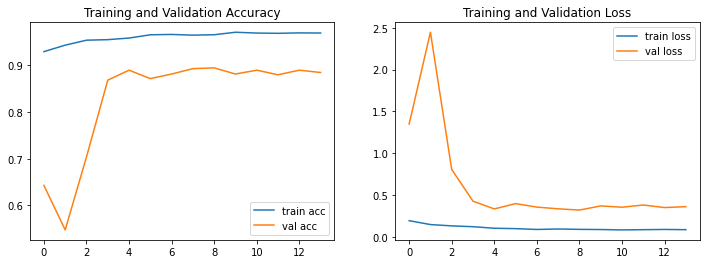

In [50]:
# plotting model accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(test_data_gen, steps=16)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test accuracy: 0.8828125
Test loss: 0.3793012797832489


In [55]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(val_data_gen, steps=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 1.0
Test loss: 0.126417338848114


In [56]:
# saving model in H5 format.
model.save('/content/drive/My Drive/Colab Notebooks/CNN_with_gan.h5')

In [57]:
import cv2
import numpy as np
from collections import Counter

data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

# making predictions off of the test set 
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(data_path + 'test' + cond)):
        img = plt.imread(data_path +'test'+ cond + img)
        img = cv2.resize(img, (img_height, img_width))
        img = np.dstack([img, img, img]) #concatenates along the third dimension
        img = img.astype('float32') / 255
        if cond =='/NORMAL/':
            label = 0
        elif cond =='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", Counter(test_labels))

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: Counter({1: 390, 0: 234})


In [61]:
import seaborn as sns
# creating a function that plots the confusion matrix
def conf_matrix(conf_mat):
    labels = ['NORMAL', 'PNEUMONIA']
    ax=sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels,
                   annot=True, fmt='d', cmap="Blues")
    ax.set_title('Confusion Matrix')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       234
           1       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



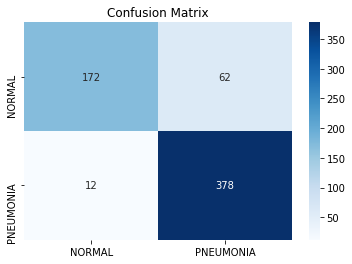

In [63]:
# calling the confusion matrix    
conf_matrix(cm)

print(classification_report(test_labels, np.round(preds)))